In [2647]:
#| default_exp centrifugal_pump

# centrifugal_pump--Design and performance

> A basic API for preliminary design and performance evaluation of centrifugal pumps

In [2648]:
#|hide
from nbdev.showdoc import *

> Pump initial parameters

Pump performance specification:

In [2649]:
pump_flow = 0.065
pump_head = 11
pump_rpm = 1200

Pump design input parameters

In [2650]:
blade_outlet_angle = 23
number_of_blades = 6
inlet_impeller_hub_diameter = 0.04
incidence = 0

In [2651]:
#|export
from dataclasses import dataclass
import numpy as np

@dataclass
class CentrifugalPumpSpecification:
        impeller_inner_diameter: float
        impeller_outer_diameter: float
        inlet_blade_height: float
        outlet_blade_height: float
        blade_clearance: float
        blade_thickness: float
        number_of_impeller_blades: int
        roughness: float
        blade_inlet_angle_rad: float
        blade_outlet_angle_rad: float
        volute_throat_area: float
        volute_height: float
        diffuser_area_ratio: float
        inlet_flow_angle_rad: float
        diameter_size_check: bool = False
        blade_height_size_check: bool = False
        Kw: float = 0.0
        Ks: float = 0.0
        Kw_check: bool = False
        Ks_check: bool = False


In [2652]:
#|export
import matplotlib.pyplot as plt


class PumpDesign:
    def __init__(self,
                 fluid: str,
                 n_d: float,
                 Q_d: float,
                 H_d: float,
                 head_coefficient: float = 0.5,
                 flow_coefficient_phi: float = 0,
                 epsilon: float=0.045e-3):
        self.fluid = fluid
        self.n_d = n_d
        self.Q_d = Q_d
        self.H_d = H_d
        self.nq = n_d * np.sqrt(Q_d) / (H_d ** (3 / 4))
        if flow_coefficient_phi == 0:
            self.flow_coefficient_phi = 3.7838e-3 * self.nq - 0.02919
        self.epsilon = epsilon
        self.head_coefficient_psi = head_coefficient

    def pump_design(self,
                    blade_outlet_angle_deg,
                    number_of_blades,
                    inlet_impeller_hub_diameter,
                    incidence,
                    flow_inlet_angle_deg = 90,
                    blade_thickness = 8e-3,
                    volute_height=5e-3,
                    diffusor_area_ratio=2,
                    blade_clearance = 0.05e-3) -> CentrifugalPumpSpecification:

        t = blade_thickness
        z = number_of_blades
        dh1 = inlet_impeller_hub_diameter
        i = incidence
        b3 = volute_height
        AR = diffusor_area_ratio
        s = blade_clearance
        beta2 = np.deg2rad(blade_outlet_angle_deg)
        alpha1 = np.deg2rad(flow_inlet_angle_deg)

        g = 9.81
        omega_d = self.n_d / 60 * 2 * np.pi
        d2 = 2 / omega_d * np.sqrt(g * self.H_d / self.head_coefficient_psi)
        u2 = omega_d * d2 / 2

        b2 = self.Q_d / (self.flow_coefficient_phi * u2 * (np.pi * d2 - t * z))
        A2 = np.pi * d2 * b2 - t * z * b2
        c2m = self.Q_d / A2
        w_theta_2 = c2m / np.tan(beta2)

        ns = 51.55 * self.nq
        Kd = 1e-13 * ns ** 3 - 7e-9 * ns ** 2 + 1e-4 * ns + 0.2661
        d1 = Kd * d2
        b1 = (d1 - dh1) / 2
        A1 = np.pi * ((dh1 + d1) / 2) * b1 - t * z * b1
        c1m = self.Q_d / A1
        beta1 = np.arctan(c1m / w_theta_2) + i

        u1 = omega_d * d1 / 2
        c_theta_1 = c1m / np.tan(alpha1)
        w_theta_1 = u1 - c_theta_1
        w1 = np.sqrt(c1m ** 2 + w_theta_1 ** 2)
        sigma = 1 - np.sin(beta2) / (z ** 0.7)
        w_theta_2 = c2m / np.tan(beta2)
        w2 = np.sqrt(c2m ** 2 + w_theta_2 ** 2)
        c_theta_2 = u2 - w_theta_2
        c_theta_2_slip = sigma * (u2 - w_theta_2)

        diameter_size_check = d1 < d2
        blade_height_size_check = b2 < b1

        print(w1)
        print(w2)
        print(c1m)
        print(c2m)
        print(w_theta_1)
        print(w_theta_2)

        Kw = (w1 - w2) / w1
        Ks = (u2 - u1) / c_theta_2

        L0 = 1/360 * c_theta_2_slip * d2/2
        A4 = 0
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        theta_list = []
        d_n_list = []
        d_1_list = []
        d_2_list = []
        for theta in range(1, 360, 1):
            coeff_1 = np.pi * L0 * 360**2 /(16 * self.Q_d * theta)
            coeff_2 = -(2 * np.pi * L0 * 360**2 * d2 / (16 * self.Q_d * theta) + 1 / 4)
            coeff_3 = (d2**2 * np.pi * L0 * 360**2 / (16 * self.Q_d * theta) - d2/4)
            d_n_root = np.roots([coeff_1, coeff_2, coeff_3])
            d_n = d_n_root[0]
            c_theta_n = L0 * 360 / (d2/2 + (d_n - d2) / 4)
            d_v = (d_n - d2) / 2
            A4 = np.pi * (d_v/2)**2
            theta_list.append(theta/(360/(2*np.pi)))
            d_n_list.append(max(d_n/2, d2/2 + b3))
            d_2_list.append(d2/2)
            d_1_list.append(d1/2)

        ax.plot(theta_list, d_n_list)
        ax.plot(theta_list, d_1_list)
        ax.plot(theta_list, d_2_list)
        # ax.set_rmax(0.25)
        ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
        ax.grid(True)

        ax.set_title("A line plot on a polar axis", va='bottom')
        plt.show()

        pump_design_parameters = CentrifugalPumpSpecification(
        impeller_inner_diameter = d1,
        impeller_outer_diameter = d2,
        inlet_blade_height = b1,
        outlet_blade_height = b2,
        volute_height = b3,
        blade_clearance = s,
        blade_thickness = t,
        number_of_impeller_blades = z,
        roughness = self.epsilon,
        blade_inlet_angle_rad= beta1,
        blade_outlet_angle_rad = beta2,
        inlet_flow_angle_rad = alpha1,
        volute_throat_area = A4,
        diffuser_area_ratio=AR,
        diameter_size_check=diameter_size_check,
        blade_height_size_check=blade_height_size_check,
        Kw=Kw,
        Ks=Ks,
        Kw_check=Kw<0.25,
        Ks_check=Ks<0.9)


        return pump_design_parameters


11.72697624942601
6.108426234380264
9.35599594076682
2.386752275852886
7.070170571560244
5.622835995703247


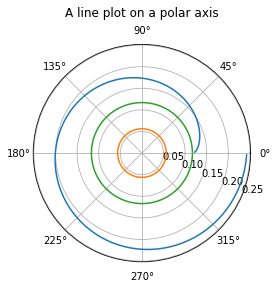

In [2653]:
design = PumpDesign(fluid="INCOMP::Water", Q_d=pump_flow, H_d=pump_head, n_d=pump_rpm)
pump = design.pump_design(blade_outlet_angle_deg=blade_outlet_angle,
                        number_of_blades=number_of_blades,
                        inlet_impeller_hub_diameter=inlet_impeller_hub_diameter,
                        incidence=0)

> Pump design evaluation


Requirements:
Inner blade diameter should be smaller than outer blade diameter

In [2654]:
print('{} < {} is {}'.format(round(pump.impeller_inner_diameter, 3), round(pump.impeller_outer_diameter, 3), pump.diameter_size_check))

0.113 < 0.234 is True


Inlet blade height have to be larger than the outlet blade height

In [2655]:
print('{} > {} is {}'.format(round(pump.inlet_blade_height, 3), round(pump.outlet_blade_height, 3), pump.blade_height_size_check))

0.036 > 0.04 is False


Small relative velocities: Kw < 0.25

In [2656]:
print('{} < 0.25 is {}'.format(round(pump.Kw, 3), pump.Kw_check))

0.479 < 0.25 is False


Stability factor: Ks < 0.9

In [2657]:
print('{} < 0.9 is {}'.format(round(pump.Ks, 3), pump.Ks_check))



0.84 < 0.9 is True


In [2658]:
#|export
from CoolProp.CoolProp import PropsSI
from scipy.optimize import root_scalar
from collections import namedtuple

class CentrifugalPump:
    def __init__(self, fluid: str, temperature: float, data: CentrifugalPumpSpecification):
        self.g = 9.81
        self.P = 101325
        self.T = temperature
        self.fluid = fluid
        self.d1 = data.impeller_inner_diameter
        self.d2 = data.impeller_outer_diameter
        self.b1 = data.inlet_blade_height
        self.b2 = data.outlet_blade_height
        self.b3 = data.volute_height
        self.s = data.blade_clearance
        self.t = data.blade_thickness
        self.z = data.number_of_impeller_blades
        self.epsilon = data.roughness
        self.beta1 = data.blade_inlet_angle_rad
        self.beta2 = data.blade_outlet_angle_rad
        self.alpha1 = data.inlet_flow_angle_rad
        self.r1 = self.d1 / 2
        self.r2 = self.d2 / 2
        self.A1 = np.pi * self.d1 * self.b1
        self.A2 = np.pi * self.d2 * self.b2
        self.A1r = self.A1 - self.t * self.z * self.b1
        self.A2r = self.A2 - self.t * self.z * self.b2
        self.A4 = data.volute_throat_area
        self.A5 = self.A4 * data.diffuser_area_ratio

    def _friction_colebrook(self, f, dh, Re):
        res = 1 / np.sqrt(f) + 2 * np.log10(
            (self.epsilon / dh) / 3.7 + 2.51 / (Re * np.sqrt(f))
        )
        return res

    def _friction_factor(self, a1, a2, temperature, v_avg):
        dh = 2 * (a2 * self.b2 + a1 * self.b1) / (a1 + a2 + self.b1 + self.b1)
        v = PropsSI("V", "T", temperature, "P", self.P, self.fluid)
        rho = PropsSI('D', 'T', temperature, 'P', self.P, self.fluid)
        Re = rho * v_avg * dh / v
        f0 = 0.25 * (np.log((self.epsilon / dh) / 3.7 + 5.74 / Re ** 0.9)) ** (-2)
        f = root_scalar(
            method="bisect",
            f=self._friction_colebrook,
            x0=f0,
            args=(dh, Re),
            bracket=[0.0001, 300],
        ).root
        return f

    def _pump_friction_loss(self, v1: float, v2: float, temperature: float):
        L = (self.d2 - self.d1) / (2 * np.sin(self.beta2))
        a1 = np.pi * self.d1 / self.z * np.sin(self.beta1)
        a2 = np.pi * self.d2 / self.z * np.sin(self.beta2)
        dh = 2 * (a2 * self.b2 + a1 * self.b1) / (a1 + a2 + self.b1 + self.b1)
        v_avg = (v1 + v2) / 2
        f = self._friction_factor(a1=a1, a2=a2, temperature=temperature, v_avg=v_avg)
        Hl_f = f * L * v_avg ** 2 / (dh * 2 * self.g)

        return Hl_f

    def _pump_incidence_loss(self, beta1, beta1_fl, w1):
        lmda = np.sin(beta1_fl) / np.sin(2 * beta1_fl - beta1) - np.sqrt(
            (np.sin(beta1_fl) ** 2 - np.sin(beta1) * np.sin(2 * beta1_fl - beta1))
            / (np.sin(2 * beta1_fl - beta1)) ** 2
        )
        Hl_inc = (
            w1 ** 2
            / (2 * self.g)
            * (1 / lmda) ** 2
            * (1 - lmda * np.sin(beta1_fl) / np.sin(beta1)) ** 2
        )
        return Hl_inc

    def _pump_leak_loss_open(self, Hth):
        a2 = np.pi * self.d2 / self.z * np.sin(self.beta2)
        nq = 20
        Hl_leak_ratio = (2.5 * self.s / self.d2) / (
            np.sqrt(self.b2 / self.d2 * (1 - self.d1 / self.d2))
            * (self.t / a2)
            * nq ** 0.1
            * np.sin(self.beta2) ** 1.2
            * np.sin(self.beta1) ** 0.4
        )
        return Hl_leak_ratio * Hth

    def _pump_leak_loss_closed(self, Q, Hth, omega, w1: float, w2: float, temperature: float):
        Hl_stat = Hth - (omega / 2) ** 2 * (self.d2 ** 2 - self.d1 ** 2) / (8 * self.g)
        a1 = np.pi * self.d1 / self.z * np.sin(self.beta1)
        a2 = np.pi * self.d2 / self.z * np.sin(self.beta2)
        w_avg = (w1 + w2) / 2
        f = self._friction_factor(a1=a1, a2=a2, temperature=temperature, v_avg=w_avg)
        L_gap = (self.d2 - self.d1) / 2
        v_gap = np.sqrt(2 * self.g * Hl_stat / (f * L_gap / self.s + 0.5 + 0.5))
        A_gap = np.pi * self.d2 * self.s
        Q_leak = v_gap * A_gap
        eta_vol = Q / (Q + Q_leak)
        return eta_vol

    def _pump_diffusion_loss(self, w1):
        Hl_d = 0.25 * w1 ** 2 / (2 * self.g)
        return Hl_d

    def _volute_friction_loss(self, Q, temperature):
        dh_volute = 4 * self.A4 / (4 * self.b3)
        d3 = self.d2 + 2 * self.b3
        c4m = Q / self.A4
        v = PropsSI("V", "T", temperature, "P", self.P, self.fluid)
        rho = PropsSI('D', 'T', temperature, 'P', self.P, self.fluid)
        Re = rho * c4m * dh_volute / v
        f0 = 0.25 * (np.log((self.epsilon / dh_volute) / 3.7 + 5.74 / Re ** 0.9)) ** (
            -2
        )
        f = root_scalar(
            method="bisect",
            f=self._friction_colebrook,
            x0=f0,
            args=(dh_volute, Re),
            bracket=[0.0001, 100],
        ).root

        Hl_f_v = f * (4 * d3 * self.b3 * c4m ** 2) / (dh_volute ** 2 * 2 * self.g)
        return Hl_f_v

    def _volute_radial_loss(self, c2r):
        Hl_radial_v = c2r ** 2 / (2 * self.g)
        return Hl_radial_v

    def _volute_head_loss(self, Q, c_theta_2):
        c4m = Q / self.A4
        d4 = self.d2 + self.b3 + np.sqrt(self.A4 / np.pi) / 2
        c_theta_4 = c_theta_2 * self.d2 / d4
        Hl_h_v = 0.8 * (c_theta_4 ** 2 - c4m ** 2) / (2 * self.g)
        return Hl_h_v

    def _volute_diffuser_loss(self, Q):
        cp = 2 * ((self.A4 / self.A5) - (self.A4 / self.A5) ** 2)
        delta_diff = 1 - cp
        c4m = Q / self.A4
        Hl_diff_v = delta_diff * c4m ** 2 / (2 * self.g)
        return Hl_diff_v

    def _power_disk_friction(self, temperature, u2):
        v = PropsSI("V", "T", temperature, "P", self.P, self.fluid)
        rho = PropsSI('D', 'T', temperature, 'P', self.P, self.fluid)
        k = 7.3e-4 * (2 * v * 1e6 / (u2 * self.d2)) ** (1 / 8)
        P_disk = k * rho * u2 ** 3 * self.d2 * (self.d2 + 5 * self.s)
        return P_disk

    def pump_head(self, Q, n, temperature):
        omega = n / 60 * 2 * np.pi

        c1m = Q / self.A1r
        c2m = Q / self.A2r

        u1 = omega * self.r1
        u2 = omega * self.r2

        c_theta_1 = c1m / np.tan(self.alpha1)
        c1 = np.sqrt(c1m ** 2 + c_theta_1 ** 2)
        w_theta_1 = u1 - c_theta_1
        w1 = np.sqrt(c1m ** 2 + w_theta_1 ** 2)
        beta1_fl = np.arctan(c1m / w_theta_1)
        incidence = self.beta1 - beta1_fl

        sigma = 1 - np.sin(self.beta2) / (self.z ** 0.7)

        w_theta_2 = c2m / np.tan(self.beta2)
        w2 = np.sqrt(c2m ** 2 + w_theta_2 ** 2)
        c_theta_2_slip = sigma * (u2 - w_theta_2)
        w_theta_2_slip = u2 - c_theta_2_slip
        beta2_fl = np.arctan(c2m / w_theta_2_slip)

        Hth = 1 / self.g * (u2 * c_theta_2_slip - u1 * c_theta_1)
        Hl_f = self._pump_friction_loss(v1=w1, v2=w2, temperature=temperature)
        Hl_inc = self._pump_incidence_loss(beta1=self.beta1, beta1_fl=beta1_fl, w1=w1)
        Hl_leak = self._pump_leak_loss_open(Hth=Hth)
        Hl_d = self._pump_diffusion_loss(w1=w1)
        Hl_f_v = self._volute_friction_loss(Q=Q, temperature=temperature)
        Hl_r_v = self._volute_radial_loss(c2r=c2m)
        Hl_h_v = self._volute_head_loss(Q=Q, c_theta_2=c_theta_2_slip)
        Hl_diff_v = self._volute_diffuser_loss(Q=Q)
        H_out = (
            Hth - Hl_f - Hl_inc - Hl_leak - Hl_d - Hl_f_v - Hl_r_v - Hl_h_v - Hl_diff_v
        )

        rho = PropsSI('D', 'T', temperature, 'P', self.P, self.fluid)

        P_disk = self._power_disk_friction(temperature=temperature, u2=u2)
        P_hyd = Hth * self.g * rho * Q
        P_out = H_out * self.g * rho * Q
        P_in = P_hyd + P_disk
        eta = P_out / P_in

        PumpPerformance = namedtuple('PumpPerformance', ['head',
                                                         'head_incidence',
                                                         'head_theoretical',
                                                         'pump_friction_loss',
                                                         'pump_incidence_loss',
                                                         'pump_diffusion_loss',
                                                         'volute_friction_loss',
                                                         'volute_radial_loss',
                                                         'volute_head_loss',
                                                         'volute_diffuser_loss',
                                                         'power_in',
                                                         'power_out',
                                                         'pump_efficiency'])

        return PumpPerformance(H_out,
                               np.rad2deg(self.beta1 - beta1_fl),
                               Hth,
                               Hl_f,
                               Hl_inc,
                               Hl_d,
                               Hl_f_v,
                               Hl_r_v,
                               Hl_h_v,
                               Hl_diff_v,
                               P_in,
                               P_out,
                               eta)


In [2659]:
pump = CentrifugalPump(fluid="INCOMP::Water", temperature=300, data=pump)

In [2660]:




results = pump.pump_head(Q=pump_flow, n=pump_rpm, temperature=300)
print(results)

PumpPerformance(head=7.965931086529011, head_incidence=19.30699777319772, head_theoretical=12.065840806822179, pump_friction_loss=0.21761817409659587, pump_incidence_loss=0.6401809634644267, pump_diffusion_loss=1.0755774817392718, volute_friction_loss=1.0482659816460323e-05, volute_radial_loss=0.2903458932868975, volute_head_loss=0.8550415035976331, volute_diffuser_loss=0.7046004966682397, power_in=7955.119912461732, power_out=5070.495307530582, pump_efficiency=0.6373876652176704)
